# Autoencoders

## Introduction

**Autoencoders** constitute a class of neural architectures designed to learn compressed
data representations through an encoding-decoding process. These networks are trained in
an unsupervised manner to reconstruct their own inputs, forcing the network to capture
the most relevant features of the data in a reduced dimensionality representation called
latent space.

The fundamental architecture of an autoencoder consists of two main components: the
encoder, which transforms the input into a compressed latent representation, and the
decoder, which reconstructs the original input from this representation. During training
with normal data, the autoencoder learns to minimize reconstruction error, implicitly
capturing the underlying distribution of the data. This property is especially useful for
anomaly detection: when atypical or abnormal data is presented, the trained autoencoder
produces low-quality reconstructions, manifesting significantly higher reconstruction
errors that allow identifying these anomalies.

## Environment setup and data generation

To demonstrate the capability of autoencoders in anomaly detection, it is necessary to
generate synthetic time series containing both normal patterns and controlled anomalies.
Normal time series are constructed by combining deterministic components (trend and
seasonality) with stochastic noise, while anomalies are subsequently injected as abrupt
deviations from these established patterns.

Environment configured correctly
GENERATING DATA

Time series generated: 1000 points
Anomalies injected: 5
Anomaly positions: [np.int64(136), np.int64(153), np.int64(156), np.int64(630), np.int64(656)]


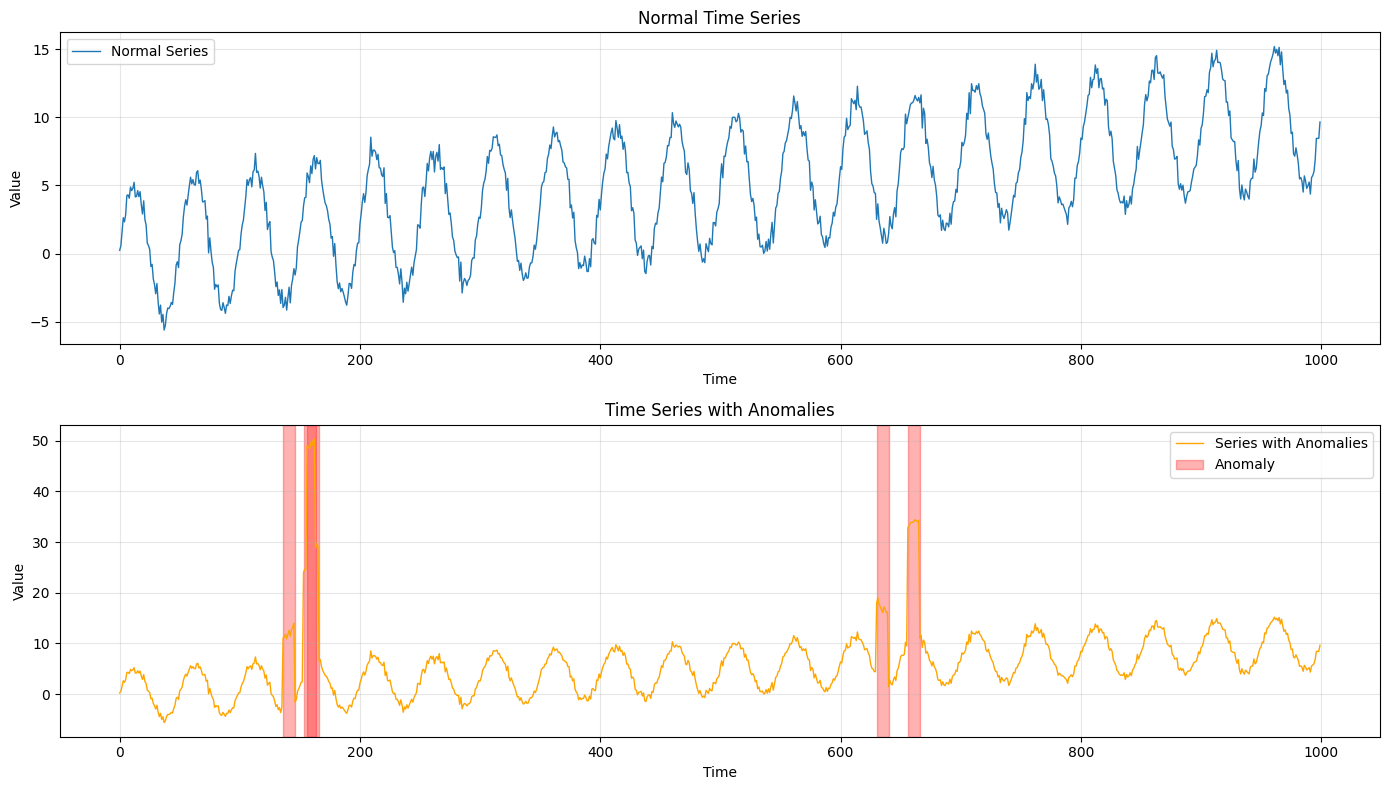

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
torch.manual_seed(42)

print("Environment configured correctly")

def generate_normal_time_series(n_points=1000):
    """
    Generates a 'normal' time series with predictable patterns.
    """
    t = np.arange(n_points)
    trend = 0.01 * t
    seasonal = 5 * np.sin(2 * np.pi * t / 50)
    noise = np.random.normal(0, 0.5, n_points)
    series = trend + seasonal + noise
    return series

def inject_anomalies(series, n_anomalies=5, type='spike'):
    """
    Injects anomalies into the time series.

    Args:
        series: Original time series
        n_anomalies: Number of anomalies to inject
        type: 'spike' or 'dip' or 'flat'
    """
    series_with_anomalies = series.copy()
    anomaly_indices = np.random.choice(
        range(100, len(series) - 100),
        size=n_anomalies,
        replace=False
    )

    for idx in anomaly_indices:
        if type == 'spike':
            series_with_anomalies[idx:idx+10] += np.random.uniform(15, 25)
        elif type == 'dip':
            series_with_anomalies[idx:idx+10] -= np.random.uniform(15, 25)
        elif type == 'flat':
            series_with_anomalies[idx:idx+20] = np.mean(series)

    return series_with_anomalies, anomaly_indices

print("=" * 60)
print("GENERATING DATA")
print("=" * 60)

normal_series = generate_normal_time_series(1000)
series_with_anomalies, anomaly_indices = inject_anomalies(
    normal_series,
    n_anomalies=5,
    type='spike'
)

print(f"\nTime series generated: {len(normal_series)} points")
print(f"Anomalies injected: {len(anomaly_indices)}")
print(f"Anomaly positions: {sorted(anomaly_indices)}")

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

axes[0].plot(normal_series, label='Normal Series', linewidth=1)
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Value')
axes[0].set_title('Normal Time Series')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(series_with_anomalies, label='Series with Anomalies', linewidth=1, color='orange')
for idx in anomaly_indices:
    axes[1].axvspan(idx, idx+10, alpha=0.3, color='red', label='Anomaly' if idx == anomaly_indices[0] else '')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Value')
axes[1].set_title('Time Series with Anomalies')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Data preparation using sliding windows

Applying autoencoders to time series requires transforming the one-dimensional sequence
into a set of fixed-length windows. This sliding window technique allows capturing local
temporal patterns and provides multiple training examples from a single series. Each
window represents a subsequence that the autoencoder will learn to reconstruct, and
normalization of this data is essential to stabilize the training process.

In [2]:
def create_windows(series, window_size=50):
    """
    Converts the time series into sliding windows.

    Args:
        series: Time series
        window_size: Size of each window

    Returns:
        Array of windows
    """
    windows = []
    for i in range(len(series) - window_size + 1):
        window = series[i:i + window_size]
        windows.append(window)
    return np.array(windows)

WINDOW_SIZE = 50

print("\n" + "=" * 60)
print("PREPARING DATA")
print("=" * 60)

normal_windows = create_windows(normal_series, WINDOW_SIZE)

print(f"\nWindows created: {normal_windows.shape}")
print(f"Each window has {WINDOW_SIZE} points")

scaler = StandardScaler()
normal_windows_scaled = scaler.fit_transform(normal_windows)

print(f"Data normalized: Mean≈0, Std≈1")

windows_tensor = torch.FloatTensor(normal_windows_scaled)
train_dataset = TensorDataset(windows_tensor, windows_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

print(f"DataLoader created: {len(train_loader)} batches")


PREPARING DATA

Windows created: (951, 50)
Each window has 50 points
Data normalized: Mean≈0, Std≈1
DataLoader created: 30 batches


## Recurrent autoencoder architecture

Autoencoders based on recurrent networks are especially suitable for sequential data, as
they can capture temporal dependencies in input patterns. The architecture consists of a
recurrent encoder that processes the input sequence and compresses the information into a
reduced dimensionality latent vector, followed by a recurrent decoder that reconstructs
the original sequence from this compressed representation.

In the context of time series, the encoder processes the input window step by step,
updating its hidden state until producing a final latent representation. The decoder uses
this representation to generate the output sequence, attempting to faithfully reproduce
the original input. The fundamental difference between using simple RNNs or LSTMs lies in
the latter's ability to maintain relevant information across longer sequences, which can
result in more accurate reconstructions and better anomaly detection.

In [3]:
class RNNAutoencoder(nn.Module):
    """
    Autoencoder using Simple RNN.

    Architecture:
    - Encoder: RNN that compresses the sequence
    - Decoder: RNN that reconstructs the sequence
    """

    def __init__(self, input_size=1, hidden_size=32, latent_size=16):
        super(RNNAutoencoder, self).__init__()
        self.hidden_size = hidden_size
        self.latent_size = latent_size

        self.encoder_rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True
        )
        self.encoder_fc = nn.Linear(hidden_size, latent_size)
        self.decoder_fc = nn.Linear(latent_size, hidden_size)
        self.decoder_rnn = nn.RNN(
            input_size=hidden_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True
        )
        self.output_fc = nn.Linear(hidden_size, input_size)

    def encode(self, x):
        """Encodes the sequence to latent representation."""
        _, hidden = self.encoder_rnn(x)
        hidden = hidden.squeeze(0)
        latent = self.encoder_fc(hidden)
        return latent

    def decode(self, latent, seq_len):
        """Decodes the latent representation back to sequence."""
        batch_size = latent.size(0)
        hidden = self.decoder_fc(latent)
        hidden = hidden.unsqueeze(0)
        decoder_input = hidden.repeat(seq_len, 1, 1).transpose(0, 1)
        rnn_out, _ = self.decoder_rnn(decoder_input, hidden)
        output = self.output_fc(rnn_out)
        return output

    def forward(self, x):
        """Complete forward pass."""
        seq_len = x.size(1)
        latent = self.encode(x)
        reconstructed = self.decode(latent, seq_len)
        return reconstructed

print("\n" + "=" * 60)
print("MODEL 1: RNN AUTOENCODER")
print("=" * 60)

rnn_model = RNNAutoencoder(input_size=1, hidden_size=32, latent_size=16)

print(rnn_model)
print(f"\nTotal parameters: {sum(p.numel() for p in rnn_model.parameters()):,}")


MODEL 1: RNN AUTOENCODER
RNNAutoencoder(
  (encoder_rnn): RNN(1, 32, batch_first=True)
  (encoder_fc): Linear(in_features=32, out_features=16, bias=True)
  (decoder_fc): Linear(in_features=16, out_features=32, bias=True)
  (decoder_rnn): RNN(32, 32, batch_first=True)
  (output_fc): Linear(in_features=32, out_features=1, bias=True)
)

Total parameters: 4,337


In [4]:
class LSTMAutoencoder(nn.Module):
    """
    Autoencoder using LSTM.

    Similar to RNN but with better long-term memory.
    """

    def __init__(self, input_size=1, hidden_size=32, latent_size=16):
        super(LSTMAutoencoder, self).__init__()
        self.hidden_size = hidden_size
        self.latent_size = latent_size

        self.encoder_lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True
        )
        self.encoder_fc = nn.Linear(hidden_size, latent_size)
        self.decoder_fc = nn.Linear(latent_size, hidden_size)
        self.decoder_lstm = nn.LSTM(
            input_size=hidden_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True
        )
        self.output_fc = nn.Linear(hidden_size, input_size)

    def encode(self, x):
        """Encodes the sequence."""
        _, (hidden, cell) = self.encoder_lstm(x)
        hidden = hidden.squeeze(0)
        latent = self.encoder_fc(hidden)
        return latent

    def decode(self, latent, seq_len):
        """Decodes the latent representation."""
        batch_size = latent.size(0)
        hidden = self.decoder_fc(latent)
        hidden = hidden.unsqueeze(0)
        cell = torch.zeros_like(hidden)
        decoder_input = hidden.repeat(seq_len, 1, 1).transpose(0, 1)
        lstm_out, _ = self.decoder_lstm(decoder_input, (hidden, cell))
        output = self.output_fc(lstm_out)
        return output

    def forward(self, x):
        """Complete forward pass."""
        seq_len = x.size(1)
        latent = self.encode(x)
        reconstructed = self.decode(latent, seq_len)
        return reconstructed

print("\n" + "=" * 60)
print("MODEL 2: LSTM AUTOENCODER")
print("=" * 60)

lstm_model = LSTMAutoencoder(input_size=1, hidden_size=32, latent_size=16)

print(lstm_model)
print(f"\nTotal parameters: {sum(p.numel() for p in lstm_model.parameters()):,}")


MODEL 2: LSTM AUTOENCODER
LSTMAutoencoder(
  (encoder_lstm): LSTM(1, 32, batch_first=True)
  (encoder_fc): Linear(in_features=32, out_features=16, bias=True)
  (decoder_fc): Linear(in_features=16, out_features=32, bias=True)
  (decoder_lstm): LSTM(32, 32, batch_first=True)
  (output_fc): Linear(in_features=32, out_features=1, bias=True)
)

Total parameters: 14,033


## Training the autoencoders

The training process of autoencoders for anomaly detection is performed exclusively with
normal data, allowing the network to learn to reconstruct typical patterns. The loss
function used is mean squared error (MSE) between the input and its reconstruction, which
measures reconstruction fidelity. During training, the optimizer adjusts the weights to
minimize this error, which implicitly makes the autoencoder capture the distribution of
normal data.


TRAINING

Training RNN Autoencoder...
------------------------------------------------------------
Epoch 10/50 - Loss: 0.597695
Epoch 20/50 - Loss: 0.028583
Epoch 30/50 - Loss: 0.016626
Epoch 40/50 - Loss: 0.018301
Epoch 50/50 - Loss: 0.014790

RNN Autoencoder trained completely

Training LSTM Autoencoder...
------------------------------------------------------------
Epoch 10/50 - Loss: 0.614990
Epoch 20/50 - Loss: 0.039827
Epoch 30/50 - Loss: 0.015699
Epoch 40/50 - Loss: 0.013646
Epoch 50/50 - Loss: 0.013290

LSTM Autoencoder trained completely


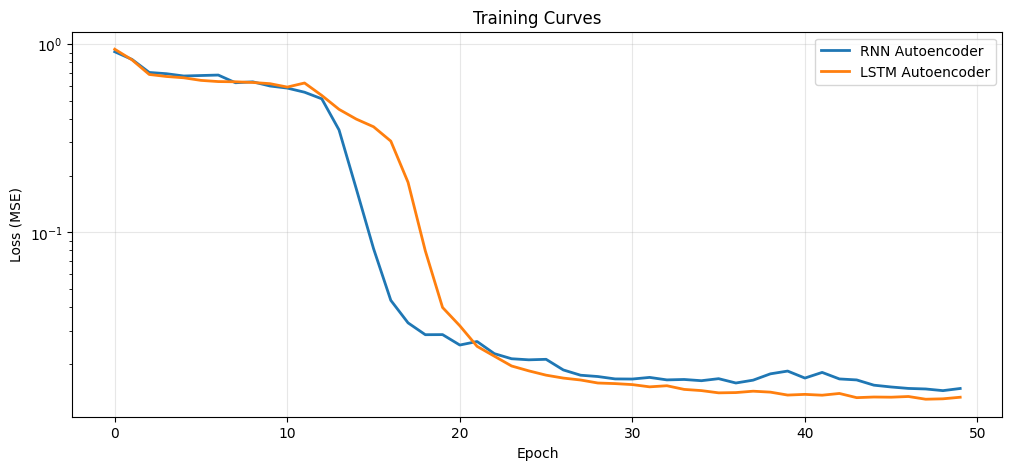


Convergence comparison:
RNN  - Final loss: 0.014790
LSTM - Final loss: 0.013290


In [5]:
def train_autoencoder(model, train_loader, epochs=50, lr=0.001, name="Model"):
    """
    Generic function to train an autoencoder.
    """
    print(f"\nTraining {name}...")
    print("-" * 60)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_history = []
    model.train()

    for epoch in range(epochs):
        epoch_loss = 0

        for batch_x, _ in train_loader:
            batch_x = batch_x.unsqueeze(-1)
            optimizer.zero_grad()
            reconstructed = model(batch_x)
            loss = criterion(reconstructed, batch_x)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        loss_history.append(avg_loss)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.6f}")

    print(f"\n{name} trained completely")
    return loss_history

print("\n" + "=" * 60)
print("TRAINING")
print("=" * 60)

rnn_history = train_autoencoder(
    rnn_model,
    train_loader,
    epochs=50,
    lr=0.001,
    name="RNN Autoencoder"
)

lstm_history = train_autoencoder(
    lstm_model,
    train_loader,
    epochs=50,
    lr=0.001,
    name="LSTM Autoencoder"
)

plt.figure(figsize=(12, 5))
plt.plot(rnn_history, label='RNN Autoencoder', linewidth=2)
plt.plot(lstm_history, label='LSTM Autoencoder', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training Curves')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.show()

print("\nConvergence comparison:")
print(f"RNN  - Final loss: {rnn_history[-1]:.6f}")
print(f"LSTM - Final loss: {lstm_history[-1]:.6f}")

## Anomaly detection through reconstruction error

Once the autoencoders are trained with normal data, anomaly detection is performed by
calculating the reconstruction error for new data windows. The fundamental principle is
that windows containing normal patterns will be reconstructed with high fidelity (low
error), while windows with anomalies will produce low-quality reconstructions (high
error). By establishing an appropriate threshold on the reconstruction error, typically
based on a percentile of the error distribution, anomalous regions of the time series can
be automatically identified.

In [6]:
def calculate_reconstruction_error(model, series, window_size, scaler):
    """
    Calculates reconstruction error for each window.

    High error indicates anomaly.
    """
    model.eval()
    windows = create_windows(series, window_size)
    windows_scaled = scaler.transform(windows)
    windows_tensor = torch.FloatTensor(windows_scaled).unsqueeze(-1)

    with torch.no_grad():
        reconstructed = model(windows_tensor)

    errors = torch.mean((windows_tensor - reconstructed) ** 2, dim=(1, 2)).numpy()
    return errors

def detect_anomalies(errors, threshold_percentile=95):
    """
    Detects anomalies based on a threshold.

    Args:
        errors: Array of reconstruction errors
        threshold_percentile: Percentile to define the threshold

    Returns:
        anomalies: Boolean array indicating anomalies
        threshold: Threshold value used
    """
    threshold = np.percentile(errors, threshold_percentile)
    anomalies = errors > threshold
    return anomalies, threshold

print("\n" + "=" * 60)
print("ANOMALY DETECTION")
print("=" * 60)

rnn_errors = calculate_reconstruction_error(
    rnn_model,
    series_with_anomalies,
    WINDOW_SIZE,
    scaler
)

lstm_errors = calculate_reconstruction_error(
    lstm_model,
    series_with_anomalies,
    WINDOW_SIZE,
    scaler
)

print(f"\nErrors calculated for {len(rnn_errors)} windows")

rnn_anomalies, rnn_threshold = detect_anomalies(rnn_errors, threshold_percentile=95)
lstm_anomalies, lstm_threshold = detect_anomalies(lstm_errors, threshold_percentile=95)

print(f"\nRNN Threshold:  {rnn_threshold:.6f}")
print(f"LSTM Threshold: {lstm_threshold:.6f}")

print(f"\nAnomalies detected:")
print(f"RNN:  {np.sum(rnn_anomalies)} windows")
print(f"LSTM: {np.sum(lstm_anomalies)} windows")


ANOMALY DETECTION

Errors calculated for 951 windows

RNN Threshold:  10.654970
LSTM Threshold: 10.378736

Anomalies detected:
RNN:  48 windows
LSTM: 48 windows


## Visualization and evaluation of results

Evaluating the effectiveness of autoencoders in anomaly detection requires both
qualitative visualization and quantitative metrics. Visualization allows visually
inspecting the correspondence between detected and actual anomalies, while metrics such
as precision, recall, and F1-score provide a numerical evaluation of system performance.


VISUALIZATION: RNN AUTOENCODER


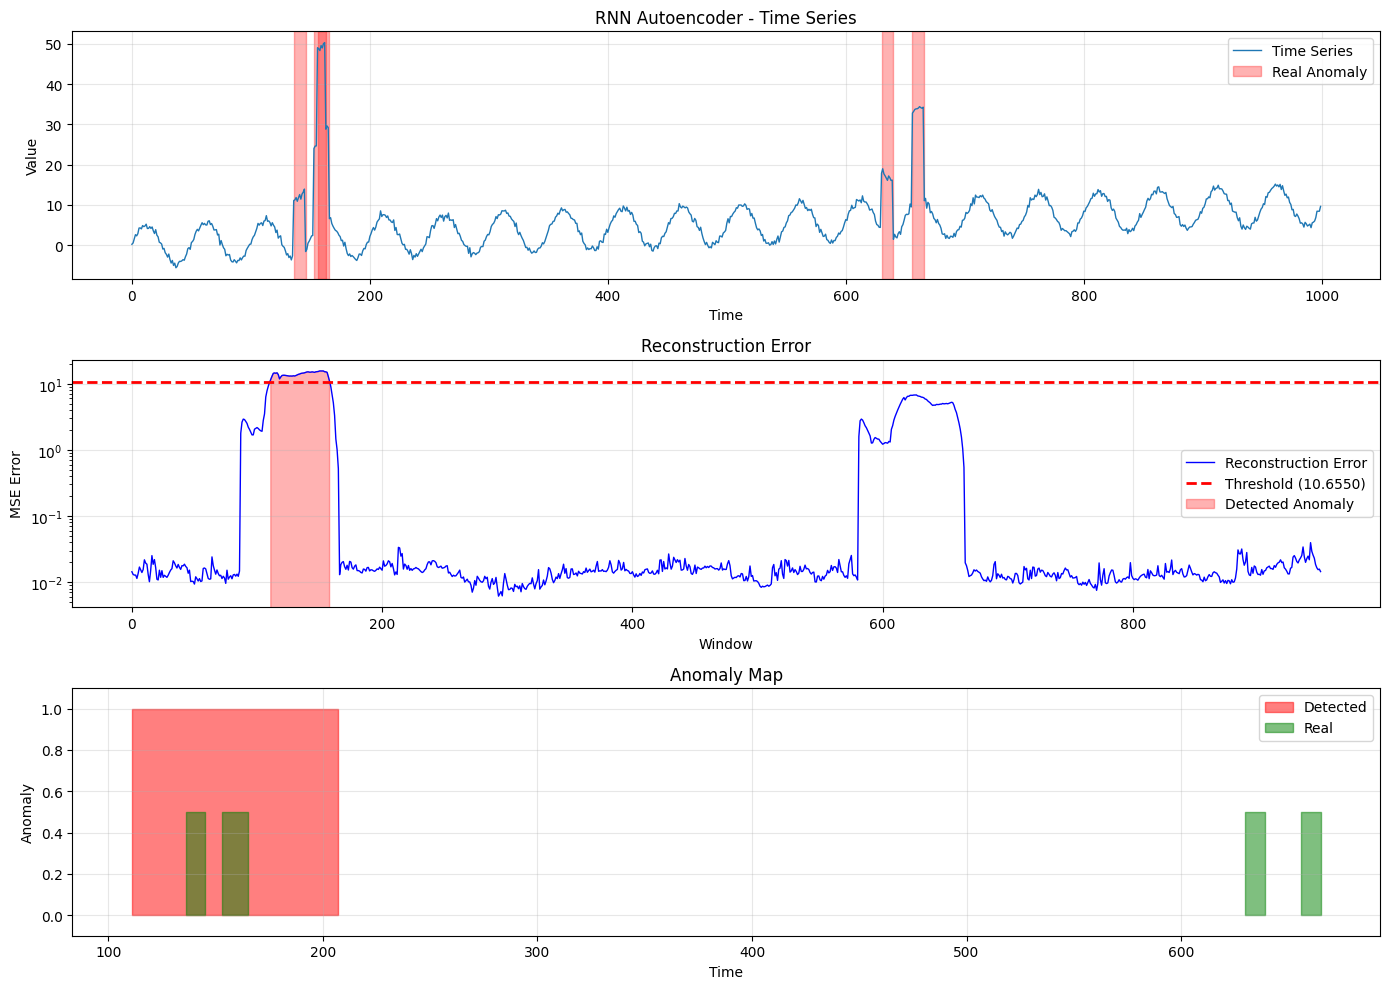


VISUALIZATION: LSTM AUTOENCODER


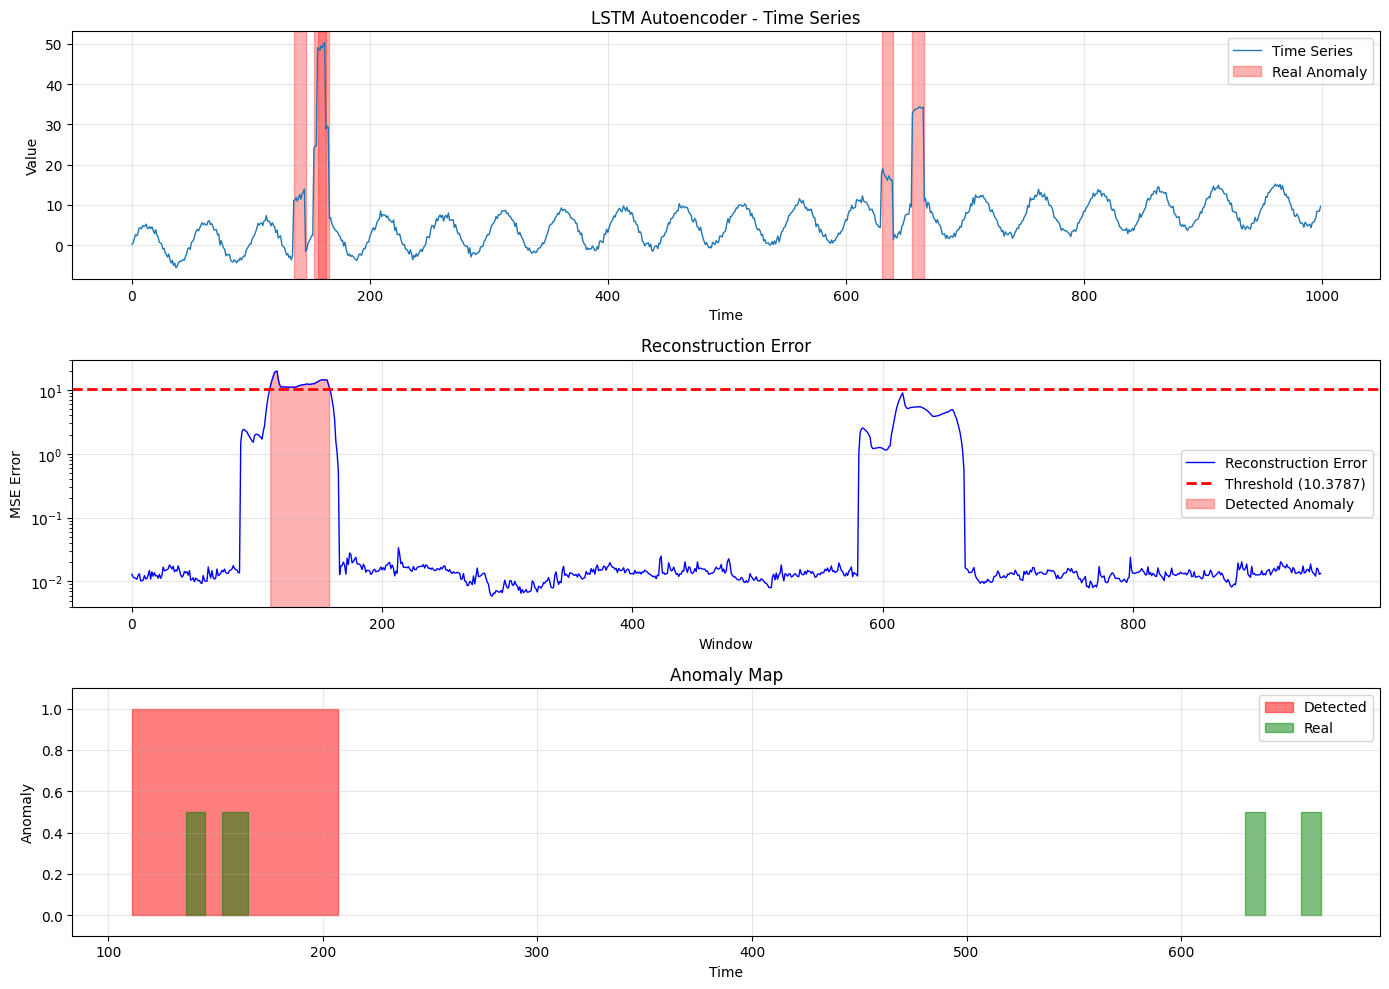

In [7]:
def visualize_detection(series, errors, anomalies, threshold, real_indices, title):
    """
    Visualizes anomaly detection.
    """
    fig, axes = plt.subplots(3, 1, figsize=(14, 10))

    axes[0].plot(series, label='Time Series', linewidth=1)
    for idx in real_indices:
        axes[0].axvspan(idx, idx+10, alpha=0.3, color='red',
                       label='Real Anomaly' if idx == real_indices[0] else '')
    axes[0].set_xlabel('Time')
    axes[0].set_ylabel('Value')
    axes[0].set_title(f'{title} - Time Series')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    axes[1].plot(errors, label='Reconstruction Error', linewidth=1, color='blue')
    axes[1].axhline(y=threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold ({threshold:.4f})')
    axes[1].fill_between(range(len(errors)), 0, errors, where=anomalies, alpha=0.3, color='red', label='Detected Anomaly')
    axes[1].set_xlabel('Window')
    axes[1].set_ylabel('MSE Error')
    axes[1].set_title('Reconstruction Error')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    axes[1].set_yscale('log')

    anomaly_map = np.zeros(len(series))
    for i, is_anomaly in enumerate(anomalies):
        if is_anomaly:
            anomaly_map[i:i+WINDOW_SIZE] = 1

    axes[2].fill_between(range(len(series)), 0, 1, where=anomaly_map>0, alpha=0.5, color='red', label='Detected')

    real_map = np.zeros(len(series))
    for idx in real_indices:
        real_map[idx:idx+10] = 1
    axes[2].fill_between(range(len(series)), 0, 0.5, where=real_map>0, alpha=0.5, color='green', label='Real')

    axes[2].set_xlabel('Time')
    axes[2].set_ylabel('Anomaly')
    axes[2].set_title('Anomaly Map')
    axes[2].legend()
    axes[2].set_ylim(-0.1, 1.1)
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

print("\n" + "=" * 60)
print("VISUALIZATION: RNN AUTOENCODER")
print("=" * 60)

visualize_detection(
    series_with_anomalies,
    rnn_errors,
    rnn_anomalies,
    rnn_threshold,
    anomaly_indices,
    "RNN Autoencoder"
)

print("\n" + "=" * 60)
print("VISUALIZATION: LSTM AUTOENCODER")
print("=" * 60)

visualize_detection(
    series_with_anomalies,
    lstm_errors,
    lstm_anomalies,
    lstm_threshold,
    anomaly_indices,
    "LSTM Autoencoder"
)

## Quantitative model comparison

Quantitative evaluation of autoencoder performance in anomaly detection is performed
using standard binary classification metrics. Precision measures the proportion of
detected anomalies that are actually anomalies, recall (sensitivity) measures the
proportion of actual anomalies that were detected, and the F1-score provides a harmonic
mean of both metrics, offering a balanced evaluation of overall system performance.


MODEL COMPARISON

DETECTION METRICS:
------------------------------------------------------------
Metric                           RNN            LSTM
------------------------------------------------------------
Precision                     0.2371          0.2371
Recall                        0.5349          0.5349
F1-Score                      0.3286          0.3286
------------------------------------------------------------
TP                                23              23
FP                                74              74
FN                                20              20


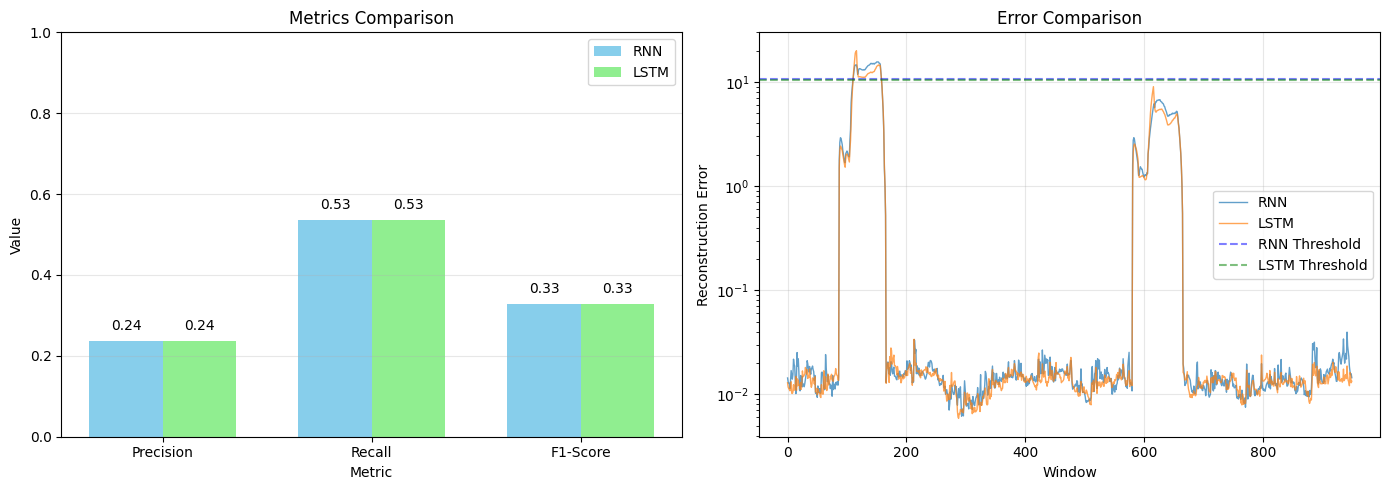


CONCLUSIONS

BEST MODEL: RNN

ANALYSIS:

1. RNN Autoencoder:
   - F1-Score: 0.3286
   - Final loss: 0.014790
   - Advantage: Simpler and faster to train
   - Disadvantage: Lower long-term memory capacity

2. LSTM Autoencoder:
   - F1-Score: 0.3286
   - Final loss: 0.013290
   - Advantage: Better long-term memory, detects complex patterns
   - Disadvantage: More parameters, slightly slower



In [8]:
def calculate_metrics(detected_anomalies, real_indices, window_size, series_length):
    """
    Calculates detection metrics.
    """
    truth = np.zeros(series_length, dtype=bool)
    for idx in real_indices:
        truth[idx:idx+10] = True

    predictions = np.zeros(series_length, dtype=bool)
    for i, is_anomaly in enumerate(detected_anomalies):
        if is_anomaly:
            predictions[i:i+window_size] = True

    true_positives = np.sum(predictions & truth)
    false_positives = np.sum(predictions & ~truth)
    false_negatives = np.sum(~predictions & truth)
    true_negatives = np.sum(~predictions & ~truth)

    precision = true_positives / (true_positives + false_positives + 1e-10)
    recall = true_positives / (true_positives + false_negatives + 1e-10)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-10)

    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'tp': true_positives,
        'fp': false_positives,
        'fn': false_negatives,
        'tn': true_negatives
    }

print("\n" + "=" * 60)
print("MODEL COMPARISON")
print("=" * 60)

rnn_metrics = calculate_metrics(
    rnn_anomalies,
    anomaly_indices,
    WINDOW_SIZE,
    len(series_with_anomalies)
)

lstm_metrics = calculate_metrics(
    lstm_anomalies,
    anomaly_indices,
    WINDOW_SIZE,
    len(series_with_anomalies)
)

print("\nDETECTION METRICS:")
print("-" * 60)
print(f"{'Metric':<20} {'RNN':>15} {'LSTM':>15}")
print("-" * 60)
print(f"{'Precision':<20} {rnn_metrics['precision']:>15.4f} {lstm_metrics['precision']:>15.4f}")
print(f"{'Recall':<20} {rnn_metrics['recall']:>15.4f} {lstm_metrics['recall']:>15.4f}")
print(f"{'F1-Score':<20} {rnn_metrics['f1']:>15.4f} {lstm_metrics['f1']:>15.4f}")
print("-" * 60)
print(f"{'TP':<20} {rnn_metrics['tp']:>15} {lstm_metrics['tp']:>15}")
print(f"{'FP':<20} {rnn_metrics['fp']:>15} {lstm_metrics['fp']:>15}")
print(f"{'FN':<20} {rnn_metrics['fn']:>15} {lstm_metrics['fn']:>15}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

metric_names = ['Precision', 'Recall', 'F1-Score']
rnn_values = [rnn_metrics['precision'], rnn_metrics['recall'], rnn_metrics['f1']]
lstm_values = [lstm_metrics['precision'], lstm_metrics['recall'], lstm_metrics['f1']]

x = np.arange(len(metric_names))
width = 0.35

axes[0].bar(x - width/2, rnn_values, width, label='RNN', color='skyblue')
axes[0].bar(x + width/2, lstm_values, width, label='LSTM', color='lightgreen')
axes[0].set_xlabel('Metric')
axes[0].set_ylabel('Value')
axes[0].set_title('Metrics Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metric_names)
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_ylim(0, 1)

for i, (rnn_val, lstm_val) in enumerate(zip(rnn_values, lstm_values)):
    axes[0].text(i - width/2, rnn_val + 0.02, f'{rnn_val:.2f}', ha='center', va='bottom')
    axes[0].text(i + width/2, lstm_val + 0.02, f'{lstm_val:.2f}', ha='center', va='bottom')

axes[1].plot(rnn_errors, label='RNN', alpha=0.7, linewidth=1)
axes[1].plot(lstm_errors, label='LSTM', alpha=0.7, linewidth=1)
axes[1].axhline(y=rnn_threshold, color='blue', linestyle='--', alpha=0.5, label='RNN Threshold')
axes[1].axhline(y=lstm_threshold, color='green', linestyle='--', alpha=0.5, label='LSTM Threshold')
axes[1].set_xlabel('Window')
axes[1].set_ylabel('Reconstruction Error')
axes[1].set_title('Error Comparison')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_yscale('log')

plt.tight_layout()
plt.show()

best_model = "LSTM" if lstm_metrics['f1'] > rnn_metrics['f1'] else "RNN"

print("\n" + "=" * 60)
print("CONCLUSIONS")
print("=" * 60)

print(f"""
BEST MODEL: {best_model}

ANALYSIS:

1. RNN Autoencoder:
   - F1-Score: {rnn_metrics['f1']:.4f}
   - Final loss: {rnn_history[-1]:.6f}
   - Advantage: Simpler and faster to train
   - Disadvantage: Lower long-term memory capacity

2. LSTM Autoencoder:
   - F1-Score: {lstm_metrics['f1']:.4f}
   - Final loss: {lstm_history[-1]:.6f}
   - Advantage: Better long-term memory, detects complex patterns
   - Disadvantage: More parameters, slightly slower
""")